In [2]:
pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.15.0
    Uninstalling wrapt-1.15.0:
      Successfully uninstalled wrapt-1.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2.13.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.1
    Uninstalling ml-dtypes-0.3.1:
      Successfully uninstalled ml-dtypes-0

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
# Import necessary libraries
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

# Import specific modules from scikit-image
import skimage.transform as transform
from skimage.filters import sobel
from skimage import io, transform, exposure, filters

# Import scikit-learn functions for evaluating the model
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.preprocessing import LabelEncoder

# Import TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow import keras

# Import scikit-learn function for splitting data into training and validation sets
from sklearn.model_selection import train_test_split
import random

In [5]:

# Specify the path for the 'textures' directory
textures_directory = '/content/textures'

# Create the 'textures' directory if it doesn't exist
if not os.path.exists(textures_directory):
    os.mkdir(textures_directory)


# Specify the path to the uploaded ZIP file for training data
zip_file_path = '/content/training.zip'

# Specify the directory where you want to extract the training data
training_path = '/content/textures'

# Extract the ZIP archive for training data
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(training_path)

# Specify the path to the uploaded ZIP file for testing data
zip_file_path = '/content/testing.zip'

# Specify the directory where you want to extract the training data
testing_path = '/content/textures'

# Extract the ZIP archive for training data
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(testing_path)

In [6]:
# Function to preprocess an image and create a pyramid
def preprocess_and_create_pyramid(image_path):
    original_image = io.imread(image_path)
    resized_image = transform.resize(original_image, (576, 576), mode='reflect', anti_aliasing=True)
    equalized_image = exposure.equalize_hist(resized_image)
    smoothed_image = filters.gaussian(equalized_image, sigma=1, multichannel=True)
    image_pyramid = [resized_image]

    for _ in range(2):
        if _ == 0:
            target_size = (288, 288)
        else:
            target_size = (144, 144)
        smoothed_image = transform.resize(smoothed_image, target_size, mode='reflect', anti_aliasing=True)
        image_pyramid.append(smoothed_image)

    return image_pyramid

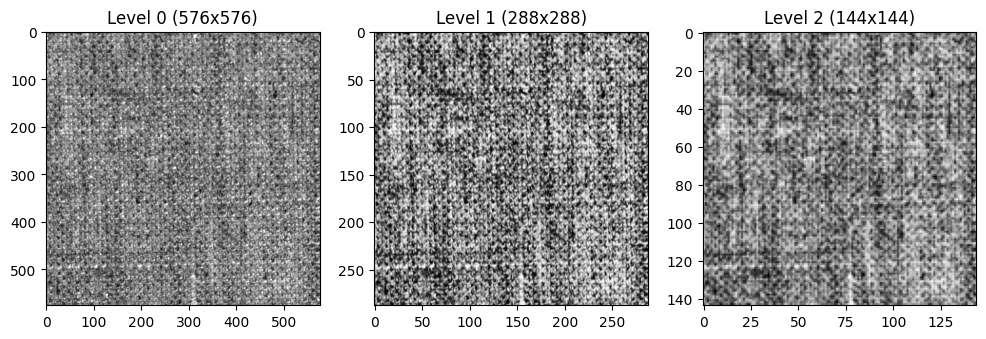

In [7]:
example_image_path = '/content/textures/training/canvas1/canvas1-a-p012.png'

# Call the preprocess_and_create_pyramid function with the example image path
pyramid_levels = preprocess_and_create_pyramid(example_image_path)

# Visualize the pyramid levels
plt.figure(figsize=(12, 4))
for i, level in enumerate(pyramid_levels):
    plt.subplot(1, len(pyramid_levels), i + 1)
    plt.imshow(level, cmap='gray')
    plt.title(f'Level {i} ({level.shape[0]}x{level.shape[1]})')

plt.show()

In [8]:
# Function to calculate Sobel histograms for an image pyramid
def calculate_sobel_histograms(image_pyramid, bin_size=256):
    sobel_histograms = []

    for level_image in image_pyramid:
        edge_image = sobel(level_image)
        histogram, _ = np.histogram(edge_image.ravel(), bins=bin_size, range=(0, 1))
        normalized_histogram = histogram / np.sum(histogram)
        sobel_histograms.append(normalized_histogram)

    return sobel_histograms

In [9]:
def compute_category_histograms(training_directory, sobel_level=0):
    # Create a dictionary to store histograms for each category
    category_histograms = {}
    # Traverse the directory structure
    for root, dirs, files in os.walk(training_directory):
        for file in files:
            # Check if the file is a PNG image
            if file.endswith('.png'):
                # Construct the full path to the image
                image_path = os.path.join(root, file)
                image_pyramid = preprocess_and_create_pyramid(image_path)
                sobel_histograms = calculate_sobel_histograms(image_pyramid)
                # Extract the category name from the subdirectory name
                category = os.path.basename(root)  # The category is the name of the subdirectory
                # If the category is not in the dictionary, add it
                if category not in category_histograms:
                    category_histograms[category] = []

                category_histograms[category].append(sobel_histograms[sobel_level])  # Specify the Sobel level

    # Initialize a dictionary to store averaged histograms
    averaged_histograms = {}

    # Calculate the average histogram for each category
    for category, histograms in category_histograms.items():
        averaged_histogram = np.mean(histograms, axis=0)
        averaged_histograms[category] = averaged_histogram

    return averaged_histograms



In [10]:
# Function to split data into training and validation sets
def split_data(data, validation_split=0.2):
    num_samples = len(data)
    num_validation_samples = int(validation_split * num_samples)
    random.shuffle(data)
    validation_set = data[:num_validation_samples]
    training_set = data[num_validation_samples:]
    return training_set, validation_set

In [11]:

# Function to classify images based on histogram distances
def classify_image(image_histogram, class_histograms):
    distances = {}
    for class_name, class_histogram in class_histograms.items():
        # Calculate the distance between image_histogram and class_histogram (e.g., Euclidean distance)
        distance = np.linalg.norm(image_histogram - class_histogram)
        distances[class_name] = distance

    # Find the class with the minimum distance
    predicted_class = min(distances, key=distances.get)
    return predicted_class

In [12]:
# Classify images and evaluate the method
def evaluate_method(data, class_histograms):
    true_labels = []
    predicted_labels = []

    for image, true_class in data:
        # Calculate the image histogram
        image_histogram = calculate_sobel_histograms(preprocess_and_create_pyramid(image))[0]

        # Classify the image
        predicted_class = classify_image(image_histogram, class_histograms)

        true_labels.append(true_class)
        predicted_labels.append(predicted_class)

    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    precision = precision_score(true_labels, predicted_labels, average='weighted')

    return accuracy, recall, precision

In [13]:
# Specify the directory where your training data is stored
training_directory = '/content/textures/training'

# Specify the directory where your testing data is stored
testing_directory = '/content/textures/testing'

# Compute category histograms
category_histograms = compute_category_histograms(training_directory,0)
category_histograms_test = compute_category_histograms(testing_directory,0)

# List to store data (image path and true class)
data = []

# Walk through subdirectories in the training directory
for root, dirs, files in os.walk(training_directory):
    for file in files:
        if file.endswith('.png'):
            image_path = os.path.join(root, file)

            category = os.path.basename(root)
            data.append((image_path, category))

# List to store data (image path and true class)
test_data = []

# Walk through subdirectories in the testing directory
for root, dirs, files in os.walk(testing_directory):
    for file in files:
        if file.endswith('.png'):
            image_path = os.path.join(root, file)
            category = os.path.basename(root)
            test_data.append((image_path, category))


# Split data into training and validation sets
training_set, validation_set = split_data(data, validation_split=0.2)

# Evaluate the method on the training set
train_accuracy, train_recall, train_precision = evaluate_method(training_set, category_histograms)

# Evaluate the method on the validation set
val_accuracy, val_recall, val_precision = evaluate_method(validation_set, category_histograms)
# Evaluate the method on the testing set
test_accuracy, test_recall, test_precision = evaluate_method(test_data, category_histograms_test)

print(f'Training Accuracy For The First Level: {train_accuracy:.4f}')
print(f'Training Recall For The First Level: {train_recall:.4f}')
print(f'Training Precision For The First Level: {train_precision:.4f}')
print()
print(f'Validation Accuracy For The First Level: {val_accuracy:.4f}')
print(f'Validation Recall For The First Level: {val_recall:.4f}')
print(f'Validation Precision For The First Level: {val_precision:.4f}')
print()
print(f'Testing Accuracy For The First Level: {test_accuracy:.4f}')
print(f'Testing Recall For The First Level: {test_recall:.4f}')
print(f'Testing Precision For The First Level: {test_precision:.4f}')

Training Accuracy For The First Level: 0.8889
Training Recall For The First Level: 0.8889
Training Precision For The First Level: 0.8886

Validation Accuracy For The First Level: 0.8333
Validation Recall For The First Level: 0.8333
Validation Precision For The First Level: 0.8452

Testing Accuracy For The First Level: 0.9000
Testing Recall For The First Level: 0.9000
Testing Precision For The First Level: 0.9028


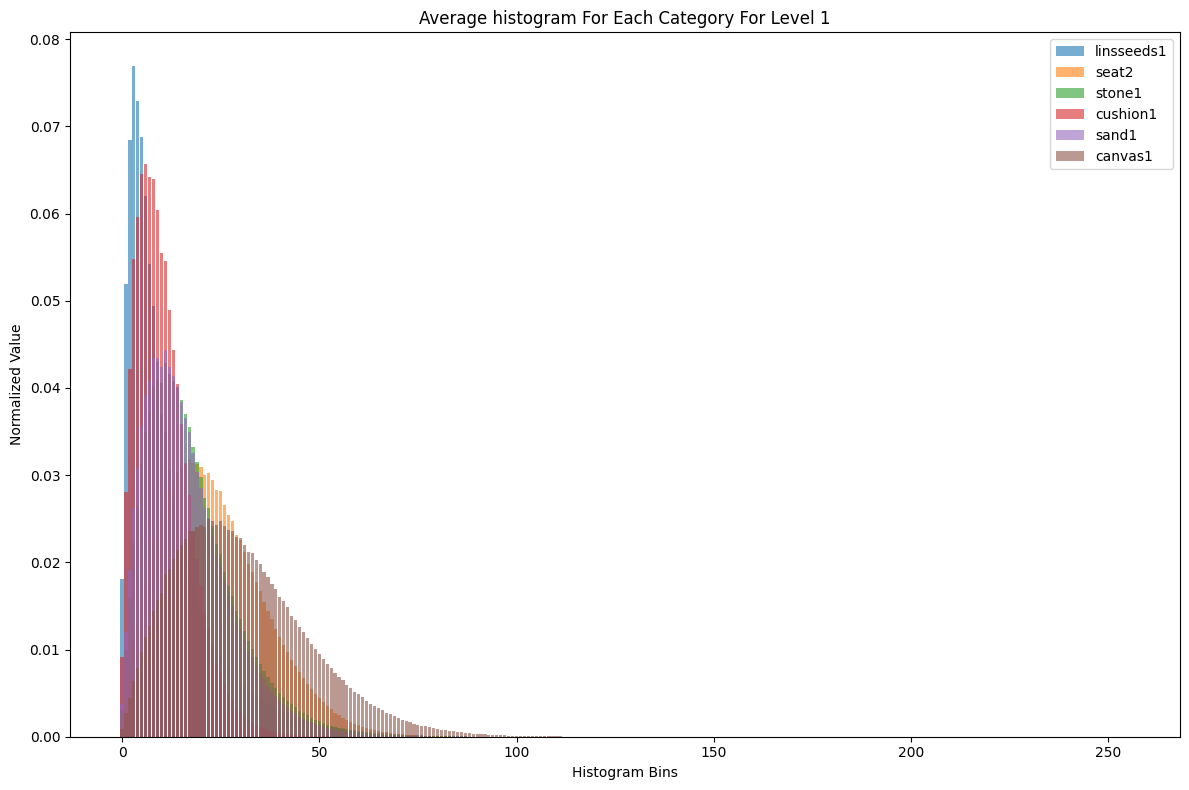

In [34]:
# Update the visualize_category_histograms function
def visualize_category_histograms(averaged_histograms, title):
    num_bins = len(list(averaged_histograms.values())[0])

    plt.figure(figsize=(12, 8))

    for category, histogram in averaged_histograms.items():
        plt.bar(range(num_bins), histogram, alpha=0.6, label=category)

    plt.xlabel('Histogram Bins')
    plt.ylabel('Normalized Value')
    plt.title(title)  # Set the title as the parameter
    plt.legend()
    plt.tight_layout()
    plt.show()


# Visualize the histograms for each category
visualize_category_histograms(category_histograms,"Average histogram For Each Category For Level 1")

In [22]:

X_train = []  # List to store training data
y_train = []  # List to store training labels

X_val = []    # List to store validation data
y_val = []    # List to store validation labels

# Iterate through training set to preprocess data
for image_path, category in training_set:
    image_pyramid = preprocess_and_create_pyramid(image_path)
    sobel_histograms = calculate_sobel_histograms(image_pyramid)
    # Flatten the input feature using NumPy
    flattened_feature = np.array(sobel_histograms).reshape(-1)
    X_train.append(flattened_feature)
    y_train.append(category)

# Iterate through the validation set to preprocess data
for image_path, category in validation_set:
    image_pyramid = preprocess_and_create_pyramid(image_path)
    sobel_histograms = calculate_sobel_histograms(image_pyramid)
    # Flatten the input feature using NumPy
    flattened_feature = np.array(sobel_histograms).reshape(-1)
    X_val.append(flattened_feature)
    y_val.append(category)

# Convert training and validation data to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

# Build an MLP model with a flattened input
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X_train.shape[1],)),  # Flatten the input
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(6, activation='softmax')  # Replace '6' with the number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Evaluate the model on the training set
train_pred = model.predict(X_train)
train_pred_classes = np.argmax(train_pred, axis=1)
train_accuracy = accuracy_score(y_train, train_pred_classes)
train_recall = recall_score(y_train, train_pred_classes, average='weighted')
train_precision = precision_score(y_train, train_pred_classes, average='weighted')

# Evaluate the model on the validation set
val_pred = model.predict(X_val)
val_pred_classes = np.argmax(val_pred, axis=1)
val_accuracy = accuracy_score(y_val, val_pred_classes)
val_recall = recall_score(y_val, val_pred_classes, average='weighted')
val_precision = precision_score(y_val, val_pred_classes, average='weighted')

print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Training Recall: {train_recall:.4f}')
print(f'Training Precision: {train_precision:.4f}')
print()
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Recall: {val_recall:.4f}')
print(f'Validation Precision: {val_precision:.4f}')


Epoch 1/10
5/5 [==============================] - 1s 53ms/step - loss: 1.7909 - accuracy: 0.2639 - val_loss: 1.7869 - val_accuracy: 0.4722
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 1.7831 - accuracy: 0.3958 - val_loss: 1.7816 - val_accuracy: 0.4167
Epoch 3/10
5/5 [==============================] - 0s 15ms/step - loss: 1.7769 - accuracy: 0.5278 - val_loss: 1.7748 - val_accuracy: 0.6389
Epoch 4/10
5/5 [==============================] - 0s 12ms/step - loss: 1.7692 - accuracy: 0.6736 - val_loss: 1.7646 - val_accuracy: 0.6389
Epoch 5/10
5/5 [==============================] - 0s 11ms/step - loss: 1.7583 - accuracy: 0.6736 - val_loss: 1.7524 - val_accuracy: 0.6389
Epoch 6/10
5/5 [==============================] - 0s 15ms/step - loss: 1.7447 - accuracy: 0.6736 - val_loss: 1.7376 - val_accuracy: 0.6389
Epoch 7/10
5/5 [==============================] - 0s 15ms/step - loss: 1.7280 - accuracy: 0.6736 - val_loss: 1.7194 - val_accuracy: 0.6389
Epoch 8/10
5/5 [===========

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
X_test = []  # List to store test data
y_test = []  # List to store test labels

# Iterate through the testing set to preprocess data
for image_path, category in test_data:
    image_pyramid = preprocess_and_create_pyramid(image_path)
    sobel_histograms = calculate_sobel_histograms(image_pyramid)
    # Flatten the input feature using NumPy
    flattened_feature = np.array(sobel_histograms).reshape(-1)
    X_test.append(flattened_feature)
    y_test.append(category)



# Convert test data to NumPy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Encode test labels
y_test = label_encoder.transform(y_test)

# Evaluate the model on the test set
test_pred = model.predict(X_test)
test_pred_classes = np.argmax(test_pred, axis=1)
test_accuracy = accuracy_score(y_test, test_pred_classes)
test_recall = recall_score(y_test, test_pred_classes, average='weighted')
test_precision = precision_score(y_test, test_pred_classes, average='weighted')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test Precision: {test_precision:.4f}')


2/2 [==============================] - 0s 6ms/step
Test Accuracy: 0.6667
Test Recall: 0.6667
Test Precision: 0.5317


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **1.5) Classification Comparison**


In Section 1.3, the code performs the following steps:
1. It computes category histograms for both the training and testing datasets using the `compute_category_histograms` function. These histograms represent the distribution of features extracted from the images in each category.
2. It walks through the subdirectories in the training and testing directories to collect image paths and their corresponding true categories.
3. The collected data is split into training and validation sets using the `split_data` function.
4. The `evaluate_method` function is used to evaluate the method on the training, validation, and test data subsets using category histograms.
5. The performance metrics, including accuracy, recall, and precision, are calculated and printed for the training, validation, and test sets.


In Section 1.4, the code performs the following steps:
1. It flattens the features extracted from the image pyramids and uses NumPy to reshape them into a single 1D array. This results in a flattened feature vector.
2. The flattened features are collected into `X_train` and `X_val` for the training and validation sets, respectively.
3. Label encoding is applied to convert the category labels into numerical values.
4. An MLP model with flattened input is constructed, compiled, and trained on the flattened training data.
5. The model is evaluated on both the training and validation sets to calculate accuracy, recall, and precision.

**Comparison:**

1. **Accuracy:** The Section 1.3 classifier based on category histograms  have higher accuracy than the Section 1.4 MLP model on the test data.This difference in accuracy could be attributed to several factors, including model complexity and the relatively small size of the training dataset.  

2. **Training Effort:** The MLP model in Section 1.4 requires training, while the category histogram method in Section 1.3 does not involve training. Training a deep neural network (like the MLP) typically requires more computational resources and time.

3. **Prediction Speed:** The category histogram method in Section 1.3 provides predictions quickly once histograms are computed. In contrast, deep neural networks, especially complex ones, might have slightly slower prediction times due to network computations.

4. **Generalization:** The MLP in Section 1.4 can potentially generalize better to new, unseen data if well-trained. It learns representations from flattened features, which can capture more complex patterns. Category histograms may be less effective for data outside the training distribution.

5. **Robustness:** The robustness depends on factors such as dataset size, model architecture, and feature representation. Deep learning models are known for their robustness when trained on large datasets, while category histograms might be less robust to variations.



# **1.6)**

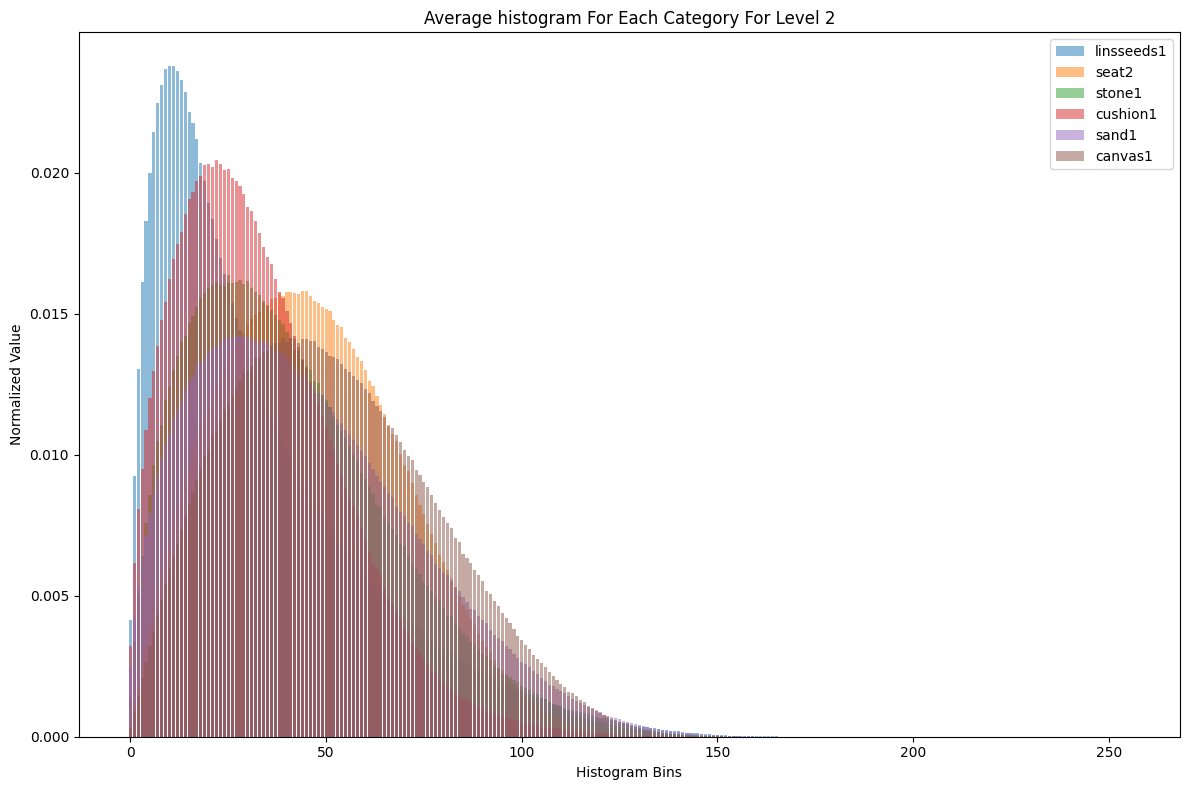

In [17]:
# Compute category histograms for the second level
category_histograms_2 = compute_category_histograms(training_directory,1)
# Visualize the histograms for the second level
visualize_category_histograms(category_histograms_2,"Average histogram For Each Category For Level 2")


In [19]:
category_histograms_test2 = compute_category_histograms(testing_directory,1)

# Evaluate the method on the training set
train_accuracy_2, train_recall_2, train_precision_2 = evaluate_method(training_set, category_histograms_2)

# Evaluate the method on the validation set
val_accuracy_2, val_recall_2, val_precision_2 = evaluate_method(validation_set, category_histograms_2)

# Evaluate the method on the testing set
test_accuracy_2, test_recall_2, test_precision_2 = evaluate_method(test_data, category_histograms_test2)

print(f'Training Accuracy For The Second Level: {train_accuracy_2:.4f}')
print(f'Training Recall For The Second Level: {train_recall_2:.4f}')
print(f'Training Precision For The Second Level: {val_precision_2:.4f}')
print()
print(f'Validation Accuracy For The Second Level: {val_accuracy_2:.4f}')
print(f'Validation Recall For The Second Level: {val_recall_2:.4f}')
print(f'Validation Precision For The Second Level: {val_precision_2:.4f}')
print()
print(f'Testing Accuracy For The Second Level: {test_accuracy_2:.4f}')
print(f'Testing Recall For The Second Level: {test_recall_2:.4f}')
print(f'Testing Precision For The Second Level: {test_precision_2:.4f}')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy For The Second Level: 0.3264
Training Recall For The Second Level: 0.3264
Training Precision For The Second Level: 0.2289

Validation Accuracy For The Second Level: 0.3611
Validation Recall For The Second Level: 0.3611
Validation Precision For The Second Level: 0.2289

Testing Accuracy For The Second Level: 0.1667
Testing Recall For The Second Level: 0.1667
Testing Precision For The Second Level: 0.0333


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


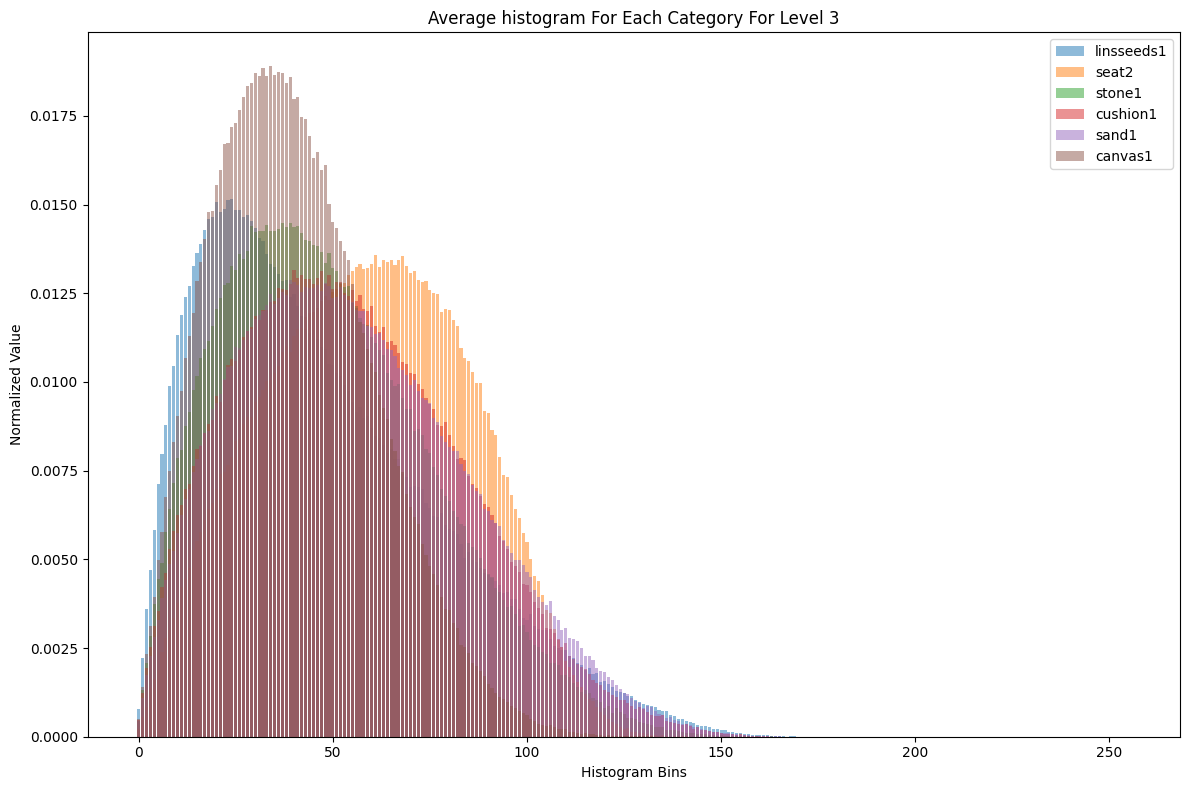

In [18]:
# Compute category histograms for the third level
category_histograms_3 = compute_category_histograms(training_directory,2)
# Visualize the histograms for the third level
visualize_category_histograms(category_histograms_3,"Average histogram For Each Category For Level 3")

In [20]:
category_histograms_test3 = compute_category_histograms(testing_directory,2)

# Evaluate the method on the training set
train_accuracy_3, train_recall_3, train_precision_3 = evaluate_method(training_set, category_histograms_3)

# Evaluate the method on the validation set
val_accuracy_3, val_recall_3, val_precision_3 = evaluate_method(validation_set, category_histograms_3)

# Evaluate the method on the testing set
test_accuracy_3, test_recall_3, test_precision_3 = evaluate_method(test_data, category_histograms_test3)

print(f'Training Accuracy For The Third Level: {train_accuracy_3:.4f}')
print(f'Training Recall For The Third Level: {train_recall_3:.4f}')
print(f'Training Precision For The Third Level: {train_precision_3:.4f}')
print()
print(f'Validation Accuracy For The Third Level: {val_accuracy_3:.4f}')
print(f'Validation Recall For The Third Level: {val_recall_3:.4f}')
print(f'Validation Precision For The Third Level: {val_precision_3:.4f}')
print()
print(f'Testing Accuracy For The Third Level: {test_accuracy_3:.4f}')
print(f'Testing Recall For The Third Level: {test_recall_3:.4f}')
print(f'Testing Precision For The Third Level: {test_precision_3:.4f}')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy For The Third Level: 0.3264
Training Recall For The Third Level: 0.3264
Training Precision For The Third Level: 0.1928

Validation Accuracy For The Third Level: 0.3611
Validation Recall For The Third Level: 0.3611
Validation Precision For The Third Level: 0.2289

Testing Accuracy For The Third Level: 0.1833
Testing Recall For The Third Level: 0.1833
Testing Precision For The Third Level: 0.1949


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


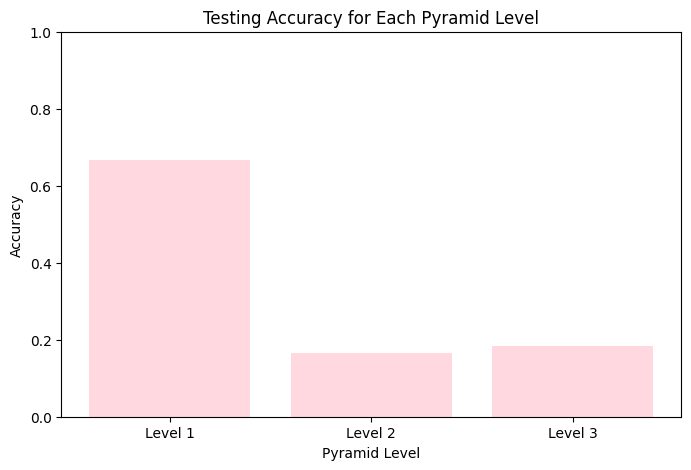

In [28]:
# Levels and testing accuracy values
levels = ['Level 1', 'Level 2', 'Level 3']
testing_accuracy = [test_accuracy, test_accuracy_2, test_accuracy_3]

# Create the bar chart
plt.figure(figsize=(8, 5))
plt.bar(levels, testing_accuracy, color='pink', alpha=0.6)
plt.title('Testing Accuracy for Each Pyramid Level')
plt.xlabel('Pyramid Level')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()


# The provided results indicate that Level 1 of the feature pyramid outperforms Levels 2 and 3 in terms of accuracy, recall, and precision. This is primarily because Level 1 captures more detailed and high-resolution information, making it more suitable for image classification. While Level 1 shows relatively consistent performance across training, validation, and testing datasets, Levels 2 and 3 perform poorly in all datasets due to the loss of fine-grained details caused by downsampling.